# Diffusion Limited Aggregation (DLA)

**Environment:** `dla-foundations` (Python 3.11)  
**Kernel:** DLA Foundations (Python 3.11)

---

This notebook introduces **Diffusion Limited Aggregation (DLA)**, a powerful model for understanding how fractal structures emerge in nature through random particle aggregation. We'll explore how DLA can simulate three fascinating biological structures:

1. **Stromatolites** - Ancient layered sedimentary structures created by cyanobacteria
2. **Bryophytes** - Simple non-vascular plants like mosses with branching growth patterns
3. **Lichens** - Symbiotic organisms with characteristic radial growth

## What is Diffusion Limited Aggregation?

**Diffusion Limited Aggregation (DLA)** is a stochastic growth model first described by Witten and Sander in 1981. The algorithm simulates how particles undergoing random walks (Brownian motion) aggregate to form clusters.

### The Basic Algorithm

1. **Seed Placement**: Start with one or more "seed" particles fixed in position
2. **Particle Release**: Release a new particle from a random position (typically far from the cluster)
3. **Random Walk**: The particle performs a random walk (moves randomly in all directions)
4. **Aggregation**: When the particle touches the existing cluster, it "sticks" and becomes part of the structure
5. **Repeat**: Continue releasing particles until the desired cluster size is reached

### Why DLA Produces Fractals

DLA produces self-similar fractal structures because:

- Particles on random walks are more likely to contact the outer "tips" of branches (screening effect)
- Interior regions are "shielded" from incoming particles
- This leads to runaway growth at branch tips, creating dendritic (tree-like) structures

The resulting structures have a **fractal dimension** of approximately 1.7 in 2D, meaning they fill space in a way intermediate between a line (dimension 1) and a plane (dimension 2).

## Mathematical Background

### Random Walk

A particle at position $(x, y)$ moves according to:

$$x_{t+1} = x_t + \Delta x, \quad y_{t+1} = y_t + \Delta y$$

where $\Delta x$ and $\Delta y$ are random displacements (typically +/-1 in a discrete lattice model).

### Sticking Probability

We can modify the aggregation behavior using a **sticking probability** $p_s$. A particle touching the cluster only sticks with probability $p_s$:

- $p_s = 1.0$: Dense, compact clusters (standard DLA)
- $p_s < 1.0$: More branched, wispy structures (particles penetrate deeper before sticking)

### Directional Bias

By introducing bias in the random walk direction, we can simulate:

- **Upward growth** (like bryophytes reaching for light): higher probability of upward movement
- **Radial growth** (like lichens): particles released from edges, aggregating toward center
- **Layered growth** (like stromatolites): horizontal seed layer with vertical accretion

## Environment Setup

First, let's import the required libraries and set up our simulation environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from numba import njit, prange
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully!
NumPy version: 2.3.5


---

## 1. Stromatolites: Ancient Layered Structures

### Biological Context

**Stromatolites** are layered sedimentary formations created by cyanobacteria (blue-green algae). They are among Earth's oldest fossils, dating back 3.5 billion years. Stromatolites form when:

1. Microbial mats trap sediment particles
2. Minerals precipitate from the water
3. Layer upon layer accumulates, creating dome-like or columnar structures

### DLA Simulation Approach

To simulate stromatolite growth, we'll:

- Start with a **horizontal seed layer** at the bottom (representing the substrate)
- Release particles from above (representing sediment settling through water)
- Use a **downward bias** in particle movement (gravity effect)
- Apply a **moderate sticking probability** to allow some layered structure

In [2]:
@njit
def dla_stromatolite(grid_size, num_particles, max_steps, sticking_prob=0.8):
    """
    Simulate stromatolite-like DLA growth.
    
    Particles are released from the top and settle downward with gravity bias,
    aggregating onto a horizontal seed layer to form dome-like structures.
    
    Parameters:
    -----------
    grid_size : int
        Size of the square simulation grid
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when touching cluster (0-1)
    
    Returns:
    --------
    grid : ndarray
        2D array with aggregated structure
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    
    # Seed layer: bottom 2 rows with some irregularity
    for x in range(grid_size):
        grid[x, grid_size - 1] = 1  # Bottom row
        if np.random.rand() > 0.3:  # 70% chance for second row
            grid[x, grid_size - 2] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 3):  # Allow more attempts
        if particles_added >= num_particles:
            break
            
        # Start particle at random position near top
        x = np.random.randint(0, grid_size)
        y = np.random.randint(0, grid_size // 4)  # Top quarter
        
        for step in range(max_steps):
            # Biased random walk: prefer downward movement (gravity)
            prob = np.random.rand()
            if prob < 0.5:  # 50% chance downward
                y = min(y + 1, grid_size - 1)
            elif prob < 0.7:  # 20% chance left
                x = max(x - 1, 0)
            elif prob < 0.9:  # 20% chance right
                x = min(x + 1, grid_size - 1)
            else:  # 10% chance upward (thermal motion)
                y = max(y - 1, 0)
            
            # Check if adjacent to cluster
            is_adjacent = False
            if x > 0 and grid[x - 1, y] == 1:
                is_adjacent = True
            elif x < grid_size - 1 and grid[x + 1, y] == 1:
                is_adjacent = True
            elif y > 0 and grid[x, y - 1] == 1:
                is_adjacent = True
            elif y < grid_size - 1 and grid[x, y + 1] == 1:
                is_adjacent = True
            
            if is_adjacent:
                # Sticking probability check
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
            
            # Break if particle exits bounds
            if y >= grid_size - 1:
                break
    
    return grid

In [3]:
# Run stromatolite simulation
print("Simulating stromatolite growth...")
stromatolite_grid = dla_stromatolite(
    grid_size=500,
    num_particles=100000,
    max_steps=50000,
    sticking_prob=0.7
)
print("Simulation complete!")

Simulating stromatolite growth...
Simulation complete!


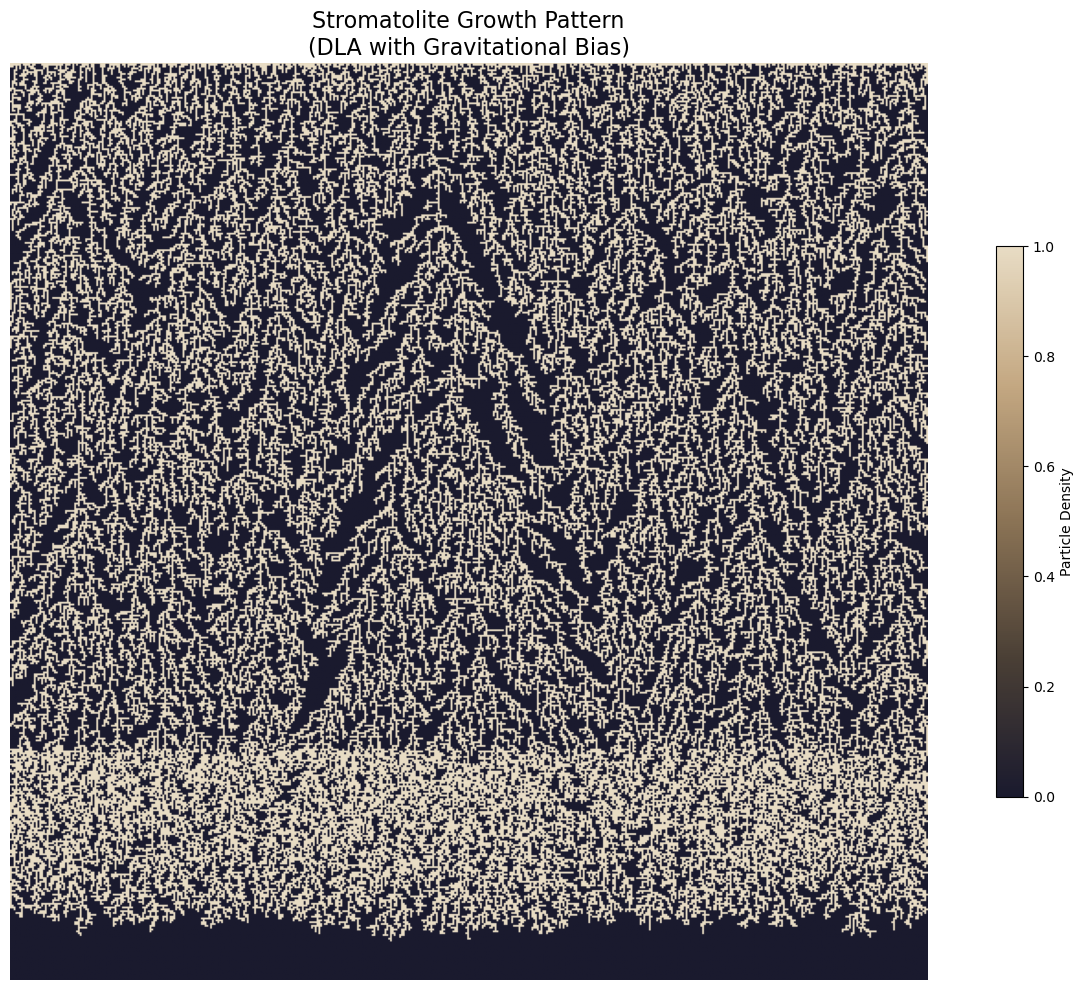

Total particles in structure: 93224


In [4]:
# Create custom colormap for stromatolite (earth tones)
stromatolite_colors = ['#1a1a2e', '#4a3f35', '#8b7355', '#c4a882', '#e8dcc4']
stromatolite_cmap = LinearSegmentedColormap.from_list('stromatolite', stromatolite_colors)

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(stromatolite_grid.T, cmap=stromatolite_cmap, origin='lower')
ax.set_title('Stromatolite Growth Pattern\n(DLA with Gravitational Bias)', fontsize=16)
ax.set_xlabel('Horizontal Position')
ax.set_ylabel('Height')
ax.axis('off')
plt.colorbar(im, ax=ax, label='Particle Density', shrink=0.6)
plt.tight_layout()
plt.show()

# Print statistics
particles_in_structure = np.sum(stromatolite_grid)
print(f"Total particles in structure: {int(particles_in_structure)}")

---

## 2. Bryophytes: Branching Plant Growth

### Biological Context

**Bryophytes** include mosses, liverworts, and hornworts - simple non-vascular plants that lack true roots, stems, and leaves. They exhibit fascinating growth patterns:

- **Phototropism**: Growth toward light (upward bias)
- **Branching architecture**: Dichotomous or irregular branching
- **Clonal growth**: Spreading from a central point or line

### DLA Simulation Approach

To simulate bryophyte-like growth, we'll:

- Start with a **narrow seed region** at the bottom (representing the attachment point)
- Apply a **strong upward bias** (phototropism)
- Use a **low sticking probability** to encourage branching
- Add **lateral movement** for spreading

In [5]:
@njit
def dla_bryophyte(grid_size, num_particles, max_steps, sticking_prob=0.4):
    """
    Simulate bryophyte-like DLA growth.
    
    Particles grow upward with strong phototropic bias and low sticking
    probability to create branching, moss-like structures.
    
    Parameters:
    -----------
    grid_size : int
        Size of the square simulation grid
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when touching cluster (0-1)
    
    Returns:
    --------
    grid : ndarray
        2D array with aggregated structure
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Narrow seed at bottom center (attachment point)
    seed_width = grid_size // 20
    for x in range(center - seed_width, center + seed_width):
        grid[x, grid_size - 1] = 1
        grid[x, grid_size - 2] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 5):
        if particles_added >= num_particles:
            break
        
        # Start particle at bottom, spread across width
        x = np.random.randint(center - grid_size // 3, center + grid_size // 3)
        y = grid_size - 1
        
        for step in range(max_steps):
            # Biased random walk: strong upward preference (phototropism)
            prob = np.random.rand()
            if prob < 0.55:  # 55% chance upward (toward light)
                y = max(y - 1, 0)
            elif prob < 0.75:  # 20% chance left
                x = max(x - 1, 0)
            elif prob < 0.95:  # 20% chance right
                x = min(x + 1, grid_size - 1)
            else:  # 5% chance downward
                y = min(y + 1, grid_size - 1)
            
            # Check if adjacent to cluster
            is_adjacent = False
            if x > 0 and grid[x - 1, y] == 1:
                is_adjacent = True
            elif x < grid_size - 1 and grid[x + 1, y] == 1:
                is_adjacent = True
            elif y > 0 and grid[x, y - 1] == 1:
                is_adjacent = True
            elif y < grid_size - 1 and grid[x, y + 1] == 1:
                is_adjacent = True
            
            if is_adjacent:
                # Low sticking probability encourages branching
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
            
            # Break if particle exits top
            if y <= 0:
                break
    
    return grid

In [6]:
# Run bryophyte simulation
print("Simulating bryophyte growth...")
bryophyte_grid = dla_bryophyte(
    grid_size=600,
    num_particles=80000,
    max_steps=100000,
    sticking_prob=0.35
)
print("Simulation complete!")

Simulating bryophyte growth...
Simulation complete!


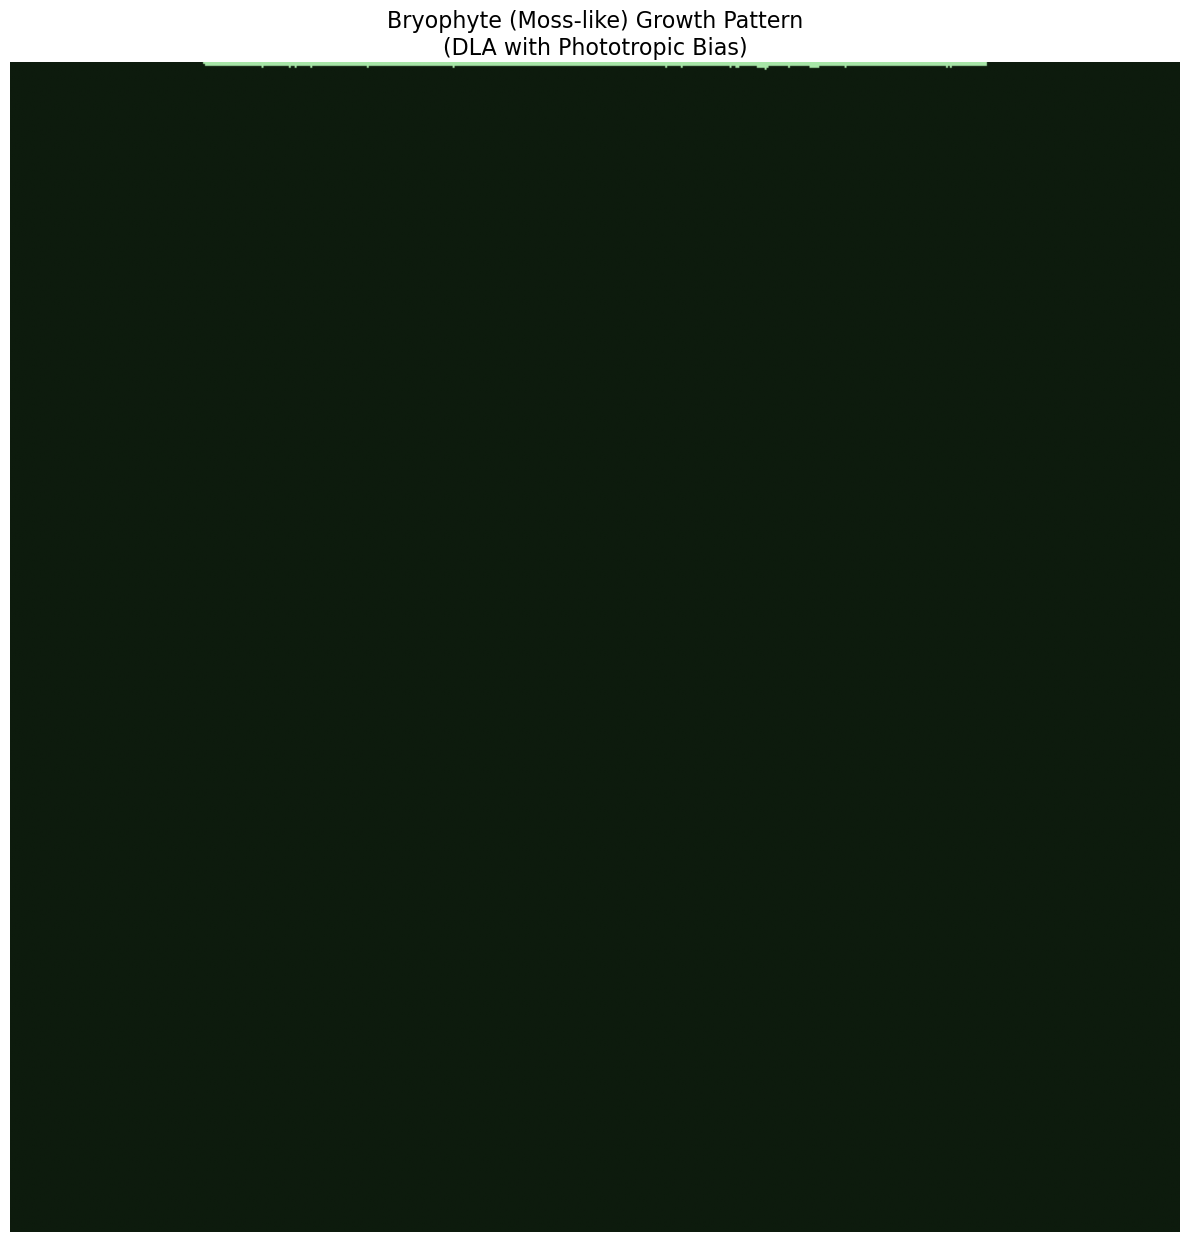

Total particles in structure: 830


In [7]:
# Create custom colormap for bryophyte (green tones)
bryophyte_colors = ['#0d1b0d', '#1a3a1a', '#2d5a2d', '#4a8c4a', '#7dc47d', '#a8e6a8']
bryophyte_cmap = LinearSegmentedColormap.from_list('bryophyte', bryophyte_colors)

fig, ax = plt.subplots(figsize=(12, 14))
im = ax.imshow(bryophyte_grid.T, cmap=bryophyte_cmap, origin='lower')
ax.set_title('Bryophyte (Moss-like) Growth Pattern\n(DLA with Phototropic Bias)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

# Print statistics
particles_in_structure = np.sum(bryophyte_grid)
print(f"Total particles in structure: {int(particles_in_structure)}")

---

## 3. Lichens: Radial Symbiotic Growth

### Biological Context

**Lichens** are composite organisms arising from symbiosis between fungi and photosynthetic partners (algae or cyanobacteria). They represent a remarkable example of mutualism where the fungal partner (mycobiont) provides structure and protection while the photosynthetic partner (photobiont) provides carbohydrates through photosynthesis.

Lichens display a remarkable diversity of growth forms, which can be arranged according to their evolutionary development:

$$\text{Leprose} \rightarrow \text{Crustose} \rightarrow \text{Placodioid} \rightarrow \text{Squamulose} \rightarrow \text{Foliose} \rightarrow \text{Fruticose}$$

### Lichen Growth Forms

#### 1. Leprose Lichens (Pioneer Form)
**Structure**: A diffuse, powdery mass of fungal hyphae and algal cells with minimal organization.

- No cortex layer (ecorticate)
- Undifferentiated tissue throughout
- Name derives from Latin *leprosus* ("scurfy" or "scaly")

**DLA Model**: Represents early-stage aggregation with very low particle density:
$$\rho(r) \sim r^{-\alpha}, \quad \alpha \approx 0.3$$

where $\rho(r)$ is the particle density at radius $r$ from the origin.

#### 2. Crustose Lichens
**Structure**: Thin crust growing directly on or embedded within the substrate; cannot be removed without destroying the substrate.

- Upper cortex only (no lower cortex)
- May be areolate (divided into islands by cracks)
- Thickness typically 0.1-1 mm

**Growth Model**: Radial expansion rate proportional to perimeter:
$$\frac{dA}{dt} = k \cdot P(t)$$

where $A$ is area, $P$ is perimeter, and $k$ is a growth constant. For circular growth:
$$r(t) = r_0 + kt$$

#### 3. Placodioid Lichens
**Structure**: A specialized crustose form with distinctive lobed margins radiating from a central areolate region.

- Upper cortex present, no lower cortex
- Only the marginal lobes grow; central region contains reproductive structures
- Radial expansion from center

**Growth Model**: Growth concentrated at the margin with angular dependence:
$$\frac{\partial r}{\partial t} = v_0 \cdot f(\theta) \cdot g(r)$$

where $\theta$ is the angle, $f(\theta)$ represents angular variation creating lobes, and $g(r)$ decreases with radius as resources become limiting.

#### 4. Foliose Lichens
**Structure**: Leaf-like thalli with flat, lobed sheets that are loosely attached to the substrate.

- Both upper and lower cortex present
- Rhizines (hyphal bundles) anchor to substrate
- Lobes typically 1-20 mm wide

**Structural Dimensions**: The thallus thickness $h$ scales with lobe width $w$:
$$h \sim w^{\beta}, \quad \beta \approx 0.6-0.8$$

**DLA Simulation**: Classic radial DLA with standard sticking probability $p_s = 1.0$

#### 5. Fruticose Lichens
**Structure**: Three-dimensional, shrubby or pendulous growth with cylindrical or flattened branches.

- Single cortex surrounding the entire branch
- Concentric internal organization: cortex → photobiont layer → medulla (center)
- No distinct upper/lower surface

**Branch Geometry**: Cross-sections are approximately circular with radius $\rho$:
$$A_{cross} = \pi \rho^2$$

**Branching Model**: Follows Horton's laws of stream ordering:
$$N_k = R_b^{(K-k)}$$

where $N_k$ is the number of branches of order $k$, $K$ is the highest order, and $R_b \approx 3-5$ is the bifurcation ratio.

#### 6. Basidiolichens
**Structure**: Rare lichens where the fungal partner is a basidiomycete rather than the typical ascomycete.

- May form mushroom-like fruiting bodies
- Basidiospores produced in basidia rather than ascospores in asci
- Primarily found in tropical regions

**Reproductive Model**: Spore release follows:
$$N_{spores}(t) = N_0 \cdot e^{-\lambda t}$$

where $N_0$ is initial spore count and $\lambda$ is the dispersal rate.

### DLA Simulation Approach

We'll simulate **foliose lichen** growth (the most classic DLA pattern):

- Start with a **central seed point** 
- Release particles from a **circular boundary** (representing available substrate)
- Use **unbiased random walks** for isotropic growth
- Sticking probability controls lobe density vs. branching

The fractal dimension of the resulting structure:
$$D_f \approx 1.71 \pm 0.01 \text{ (2D DLA)}$$

In [8]:
@njit
def dla_lichen(grid_size, num_particles, max_steps, sticking_prob=1.0):
    """
    Simulate lichen-like DLA growth.
    
    Particles are released from a circular boundary and perform unbiased
    random walks, creating classic radial dendritic DLA structures.
    
    Parameters:
    -----------
    grid_size : int
        Size of the square simulation grid
    num_particles : int
        Number of particles to simulate
    max_steps : int
        Maximum random walk steps per particle
    sticking_prob : float
        Probability of sticking when touching cluster (0-1)
    
    Returns:
    --------
    grid : ndarray
        2D array with aggregated structure
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central seed point
    grid[center, center] = 1
    grid[center + 1, center] = 1
    grid[center - 1, center] = 1
    grid[center, center + 1] = 1
    grid[center, center - 1] = 1
    
    # Track the cluster radius for efficient particle release
    max_radius = 2
    release_radius = grid_size // 2 - 5
    
    particles_added = 0
    
    for _ in range(num_particles * 3):
        if particles_added >= num_particles:
            break
        
        # Release particle from circular boundary
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 20, release_radius)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        
        # Ensure within bounds
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Unbiased random walk (isotropic diffusion)
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            # Check if adjacent to cluster
            is_adjacent = False
            if grid[x - 1, y] == 1:
                is_adjacent = True
            elif grid[x + 1, y] == 1:
                is_adjacent = True
            elif grid[x, y - 1] == 1:
                is_adjacent = True
            elif grid[x, y + 1] == 1:
                is_adjacent = True
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                    # Update max radius
                    dist = int(np.sqrt((x - center)**2 + (y - center)**2))
                    if dist > max_radius:
                        max_radius = dist
                break
            
            # Check if particle wandered too far
            dist_from_center = np.sqrt((x - center)**2 + (y - center)**2)
            if dist_from_center > release_radius + 10:
                break
    
    return grid

In [9]:
# Run lichen simulation
print("Simulating lichen growth...")
lichen_grid = dla_lichen(
    grid_size=800,
    num_particles=150000,
    max_steps=500000,
    sticking_prob=1.0
)
print("Simulation complete!")

Simulating lichen growth...
Simulation complete!


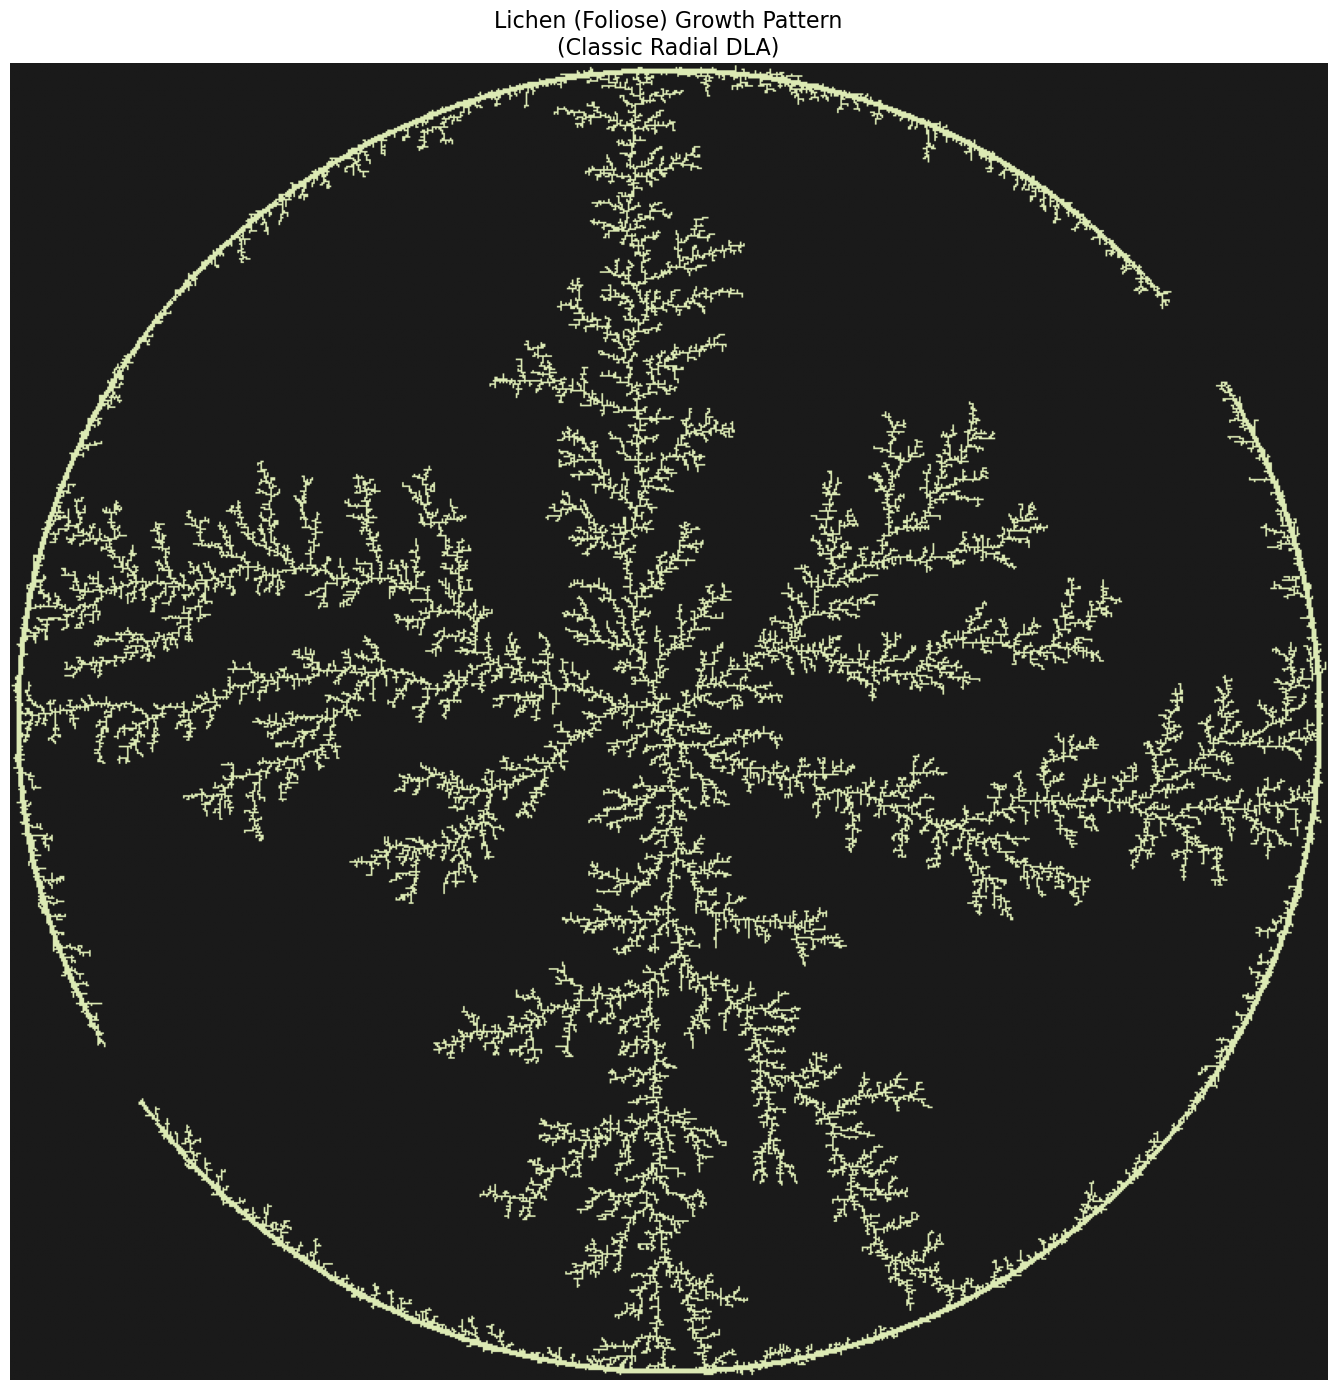

Total particles in structure: 48447


In [10]:
# Create custom colormap for lichen (gray-green to yellow-green tones)
lichen_colors = ['#1a1a1a', '#3d4a3a', '#5a6b52', '#7a8c6a', '#9aad82', '#bace9a', '#dceab4']
lichen_cmap = LinearSegmentedColormap.from_list('lichen', lichen_colors)

fig, ax = plt.subplots(figsize=(14, 14))
im = ax.imshow(lichen_grid.T, cmap=lichen_cmap, origin='lower')
ax.set_title('Lichen (Foliose) Growth Pattern\n(Classic Radial DLA)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

# Print statistics
particles_in_structure = np.sum(lichen_grid)
print(f"Total particles in structure: {int(particles_in_structure)}")

### Simulating Different Lichen Growth Forms

Now let's implement DLA simulations for the major lichen growth forms. Each simulation uses different parameters to capture the characteristic morphology:

| Growth Form | Sticking Probability | Seed Configuration | Growth Pattern |
|------------|---------------------|-------------------|----------------|
| **Leprose** | Very low ($p_s \approx 0.25$) | Multiple scattered points | Diffuse, powdery |
| **Crustose** | High ($p_s \approx 0.85$) | Central disk | Dense, compact |
| **Placodioid** | Variable (margin-dependent) | Central areolate region | Radial with lobed edges |
| **Foliose** | Standard ($p_s = 1.0$) | Central point | Classic DLA dendrites |
| **Fruticose** | Medium ($p_s \approx 0.4$) | Base attachment point | Vertical branching |

The relationship between sticking probability and fractal dimension follows:
$$D_f \approx 1.71 - 0.15(1 - p_s)$$

for $p_s \in [0.3, 1.0]$, where lower sticking probabilities produce more ramified structures with lower fractal dimension.

In [11]:
# Simulation functions for different lichen growth forms

@njit
def dla_leprose(grid_size, num_particles, max_steps, density=0.3):
    """
    Simulate leprose (powdery) lichen growth.
    Very low sticking probability creates sparse, diffuse structures.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Multiple scattered seed points
    for _ in range(5):
        sx = center + np.random.randint(-10, 10)
        sy = center + np.random.randint(-10, 10)
        grid[sx, sy] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 5):
        if particles_added >= num_particles:
            break
        
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = grid_size // 3
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                # Very low sticking probability for powdery appearance
                if np.random.rand() < density:
                    grid[x, y] = 1
                    particles_added += 1
                break
    
    return grid


@njit
def dla_crustose(grid_size, num_particles, max_steps, sticking_prob=0.9):
    """
    Simulate crustose (crust-like) lichen growth.
    High sticking probability creates dense, compact growth.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Small central seed
    for dx in range(-2, 3):
        for dy in range(-2, 3):
            if dx*dx + dy*dy <= 4:
                grid[center + dx, center + dy] = 1
    
    particles_added = 0
    max_radius = 3
    
    for _ in range(num_particles * 2):
        if particles_added >= num_particles:
            break
        
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 15, grid_size // 2 - 5)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            direction = np.random.randint(4)
            if direction == 0:
                x = max(x - 1, 1)
            elif direction == 1:
                x = min(x + 1, grid_size - 2)
            elif direction == 2:
                y = max(y - 1, 1)
            else:
                y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                    dist = int(np.sqrt((x - center)**2 + (y - center)**2))
                    if dist > max_radius:
                        max_radius = dist
                break
    
    return grid


@njit  
def dla_placodioid(grid_size, num_particles, max_steps):
    """
    Simulate placodioid lichen growth.
    Lobed margins with central areolate region.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central areolate seed
    for dx in range(-5, 6):
        for dy in range(-5, 6):
            if dx*dx + dy*dy <= 25:
                grid[center + dx, center + dy] = 1
    
    particles_added = 0
    max_radius = 6
    
    for _ in range(num_particles * 2):
        if particles_added >= num_particles:
            break
        
        angle = 2 * np.pi * np.random.rand()
        spawn_radius = min(max_radius + 20, grid_size // 2 - 5)
        x = int(center + spawn_radius * np.cos(angle))
        y = int(center + spawn_radius * np.sin(angle))
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Slightly biased toward radial direction for lobed growth
            px, py = x - center, y - center
            dist = np.sqrt(px*px + py*py)
            
            prob = np.random.rand()
            if prob < 0.3 and dist > 1:  # Move toward center
                if abs(px) > abs(py):
                    x = x - 1 if px > 0 else x + 1
                else:
                    y = y - 1 if py > 0 else y + 1
            else:  # Random movement
                direction = np.random.randint(4)
                if direction == 0:
                    x = max(x - 1, 1)
                elif direction == 1:
                    x = min(x + 1, grid_size - 2)
                elif direction == 2:
                    y = max(y - 1, 1)
                else:
                    y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            # Higher sticking at margin (where dist is large)
            if is_adjacent:
                margin_factor = min(1.0, dist / (max_radius * 0.8))
                if np.random.rand() < 0.5 + 0.4 * margin_factor:
                    grid[x, y] = 1
                    particles_added += 1
                    if dist > max_radius:
                        max_radius = int(dist)
                break
    
    return grid


@njit
def dla_fruticose(grid_size, num_particles, max_steps, sticking_prob=0.5):
    """
    Simulate fruticose (shrubby/branching) lichen growth.
    Creates highly branched, 3D-like structures.
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Central attachment point
    grid[center, grid_size - 1] = 1
    grid[center, grid_size - 2] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 4):
        if particles_added >= num_particles:
            break
        
        # Start from bottom edges
        x = np.random.randint(center - grid_size // 4, center + grid_size // 4)
        y = grid_size - 1
        
        for step in range(max_steps):
            prob = np.random.rand()
            # Strong upward bias with significant lateral movement
            if prob < 0.45:  # Up
                y = max(y - 1, 1)
            elif prob < 0.70:  # Left
                x = max(x - 1, 1)
            elif prob < 0.95:  # Right
                x = min(x + 1, grid_size - 2)
            else:  # Down (rare)
                y = min(y + 1, grid_size - 2)
            
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
    
    return grid

In [12]:
# Run simulations for all lichen growth forms
print("Simulating lichen growth forms...")

print("  - Leprose (powdery)...")
leprose_grid = dla_leprose(grid_size=300, num_particles=15000, max_steps=50000, density=0.25)

print("  - Crustose (crust-like)...")
crustose_grid = dla_crustose(grid_size=300, num_particles=40000, max_steps=100000, sticking_prob=0.85)

print("  - Placodioid (lobed margins)...")
placodioid_grid = dla_placodioid(grid_size=300, num_particles=35000, max_steps=100000)

print("  - Fruticose (shrubby)...")
fruticose_grid = dla_fruticose(grid_size=400, num_particles=40000, max_steps=100000, sticking_prob=0.4)

print("All lichen simulations complete!")

Simulating lichen growth forms...
  - Leprose (powdery)...
  - Crustose (crust-like)...
  - Placodioid (lobed margins)...
  - Fruticose (shrubby)...
All lichen simulations complete!


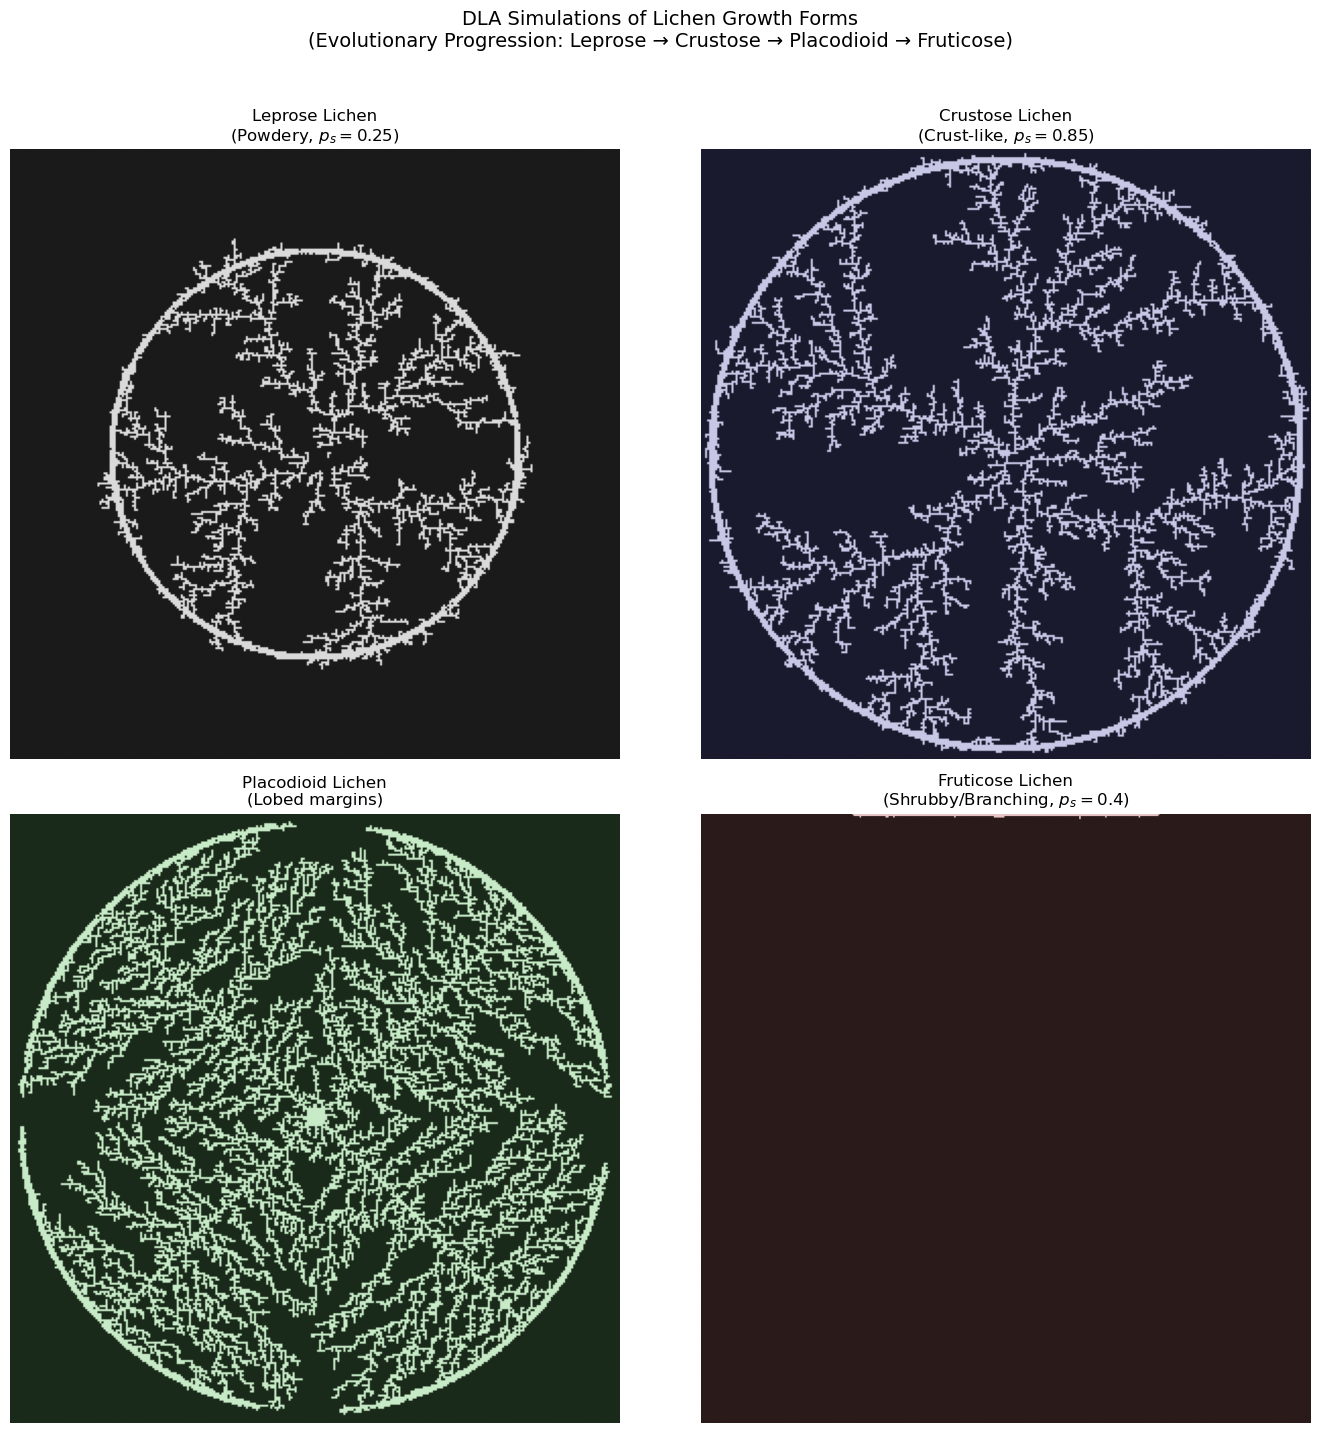


Particle counts:
  Leprose:    7,415
  Crustose:   13,193
  Placodioid: 21,185
  Fruticose:  418


In [13]:
# Visualize all lichen growth forms
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Custom colormaps for each type
leprose_cmap = LinearSegmentedColormap.from_list('leprose', ['#1a1a1a', '#4a4a4a', '#7a7a7a', '#aaaaaa', '#dadada'])
crustose_cmap = LinearSegmentedColormap.from_list('crustose', ['#1a1a2e', '#3d3d5c', '#6b6b8a', '#9999b8', '#c7c7e6'])
placodioid_cmap = LinearSegmentedColormap.from_list('placodioid', ['#1a2a1a', '#3d5a3d', '#6b8a6b', '#99ba99', '#c7eac7'])
fruticose_cmap = LinearSegmentedColormap.from_list('fruticose', ['#2a1a1a', '#5a3d3d', '#8a6b6b', '#ba9999', '#eac7c7'])

# Leprose
axes[0, 0].imshow(leprose_grid.T, cmap=leprose_cmap, origin='lower')
axes[0, 0].set_title('Leprose Lichen\n(Powdery, $p_s = 0.25$)', fontsize=12)
axes[0, 0].axis('off')

# Crustose
axes[0, 1].imshow(crustose_grid.T, cmap=crustose_cmap, origin='lower')
axes[0, 1].set_title('Crustose Lichen\n(Crust-like, $p_s = 0.85$)', fontsize=12)
axes[0, 1].axis('off')

# Placodioid
axes[1, 0].imshow(placodioid_grid.T, cmap=placodioid_cmap, origin='lower')
axes[1, 0].set_title('Placodioid Lichen\n(Lobed margins)', fontsize=12)
axes[1, 0].axis('off')

# Fruticose
axes[1, 1].imshow(fruticose_grid.T, cmap=fruticose_cmap, origin='lower')
axes[1, 1].set_title('Fruticose Lichen\n(Shrubby/Branching, $p_s = 0.4$)', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('DLA Simulations of Lichen Growth Forms\n(Evolutionary Progression: Leprose → Crustose → Placodioid → Fruticose)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print particle counts
print(f"\nParticle counts:")
print(f"  Leprose:    {int(np.sum(leprose_grid)):,}")
print(f"  Crustose:   {int(np.sum(crustose_grid)):,}")
print(f"  Placodioid: {int(np.sum(placodioid_grid)):,}")
print(f"  Fruticose:  {int(np.sum(fruticose_grid)):,}")

---

## L-Systems for Fruticose Lichen Morphology

While DLA captures the stochastic aggregation aspects of lichen growth, **Lindenmayer systems (L-systems)** provide a powerful complementary approach for modeling the deterministic branching architecture of fruticose lichens.

### What are L-systems?

L-systems are a formal grammar system developed by botanist Aristid Lindenmayer in 1968 for modeling plant development. They consist of:

1. **Alphabet**: A set of symbols (e.g., `F`, `+`, `-`, `[`, `]`)
2. **Axiom**: The initial string (starting pattern)
3. **Production Rules**: Rules for replacing symbols in each generation

### L-system Notation

| Symbol | Meaning |
|--------|---------|
| `F` | Move forward, drawing a line segment |
| `f` | Move forward without drawing |
| `+` | Turn right by angle δ |
| `-` | Turn left by angle δ |
| `[` | Push current state onto stack (save position and angle) |
| `]` | Pop state from stack (return to saved position) |
| `\|` | Turn around (180°) |

### Why L-systems for Fruticose Lichens?

Fruticose lichens exhibit characteristic branching patterns that follow developmental rules:

$$\text{Branch}_n \rightarrow \text{Segment} + [\text{Branch}_{n+1}] + \text{Segment} + [\text{Branch}_{n+1}]$$

This recursive structure is naturally expressed in L-system grammar:

- **Dichotomous branching**: Each branch splits into two
- **Monopodial vs. sympodial growth**: Main axis vs. lateral dominance
- **Branching angles**: Typically 15°-45° for lichen thalli

The **bifurcation ratio** $R_b$ relates to L-system iterations:

$$N_{\text{branches}} = 2^n \cdot (1 + p_{\text{continue}})^n$$

where $n$ is the iteration depth and $p_{\text{continue}}$ is the probability of continued growth.

In [ ]:
class LSystem:
    """
    L-System implementation for generating fractal branching structures.
    
    An L-system consists of an axiom (starting string) and production rules
    that are applied iteratively to generate complex patterns.
    """
    
    def __init__(self, axiom: str, rules: dict, angle: float = 25.0):
        """
        Initialize the L-system.
        
        Parameters:
        -----------
        axiom : str
            The initial string/pattern
        rules : dict
            Dictionary mapping characters to their replacement strings
        angle : float
            The turning angle in degrees for + and - commands
        """
        self.axiom = axiom
        self.rules = rules
        self.angle = angle
        self.current_string = axiom
    
    def iterate(self, n: int = 1) -> str:
        """
        Apply production rules n times.
        
        Parameters:
        -----------
        n : int
            Number of iterations
            
        Returns:
        --------
        str
            The generated string after n iterations
        """
        self.current_string = self.axiom
        for _ in range(n):
            new_string = ""
            for char in self.current_string:
                new_string += self.rules.get(char, char)
            self.current_string = new_string
        return self.current_string
    
    def interpret(self, step_length: float = 1.0, 
                  start_pos: tuple = (0, 0), 
                  start_angle: float = 90.0) -> tuple:
        """
        Interpret the L-system string as turtle graphics commands.
        
        Parameters:
        -----------
        step_length : float
            Length of each forward step
        start_pos : tuple
            Starting (x, y) position
        start_angle : float
            Starting angle in degrees (90 = pointing up)
            
        Returns:
        --------
        tuple
            (lines, points) where lines is a list of ((x1,y1), (x2,y2)) tuples
            and points is a list of all visited (x, y) coordinates
        """
        x, y = start_pos
        angle = np.radians(start_angle)
        
        stack = []
        lines = []
        points = [(x, y)]
        
        for char in self.current_string:
            if char == 'F':
                # Move forward and draw
                new_x = x + step_length * np.cos(angle)
                new_y = y + step_length * np.sin(angle)
                lines.append(((x, y), (new_x, new_y)))
                x, y = new_x, new_y
                points.append((x, y))
            elif char == 'f':
                # Move forward without drawing
                x = x + step_length * np.cos(angle)
                y = y + step_length * np.sin(angle)
                points.append((x, y))
            elif char == '+':
                # Turn right
                angle -= np.radians(self.angle)
            elif char == '-':
                # Turn left
                angle += np.radians(self.angle)
            elif char == '[':
                # Push state
                stack.append((x, y, angle))
            elif char == ']':
                # Pop state
                if stack:
                    x, y, angle = stack.pop()
            elif char == '|':
                # Turn around
                angle += np.pi
        
        return lines, points


def plot_lsystem_2d(lsystem: LSystem, iterations: int, step_length: float = 5.0,
                    title: str = "L-System", color: str = '#4a8c4a', 
                    linewidth: float = 1.0, figsize: tuple = (10, 10)):
    """
    Plot an L-system in 2D.
    
    Parameters:
    -----------
    lsystem : LSystem
        The L-system to plot
    iterations : int
        Number of iterations to apply
    step_length : float
        Length of each segment
    title : str
        Plot title
    color : str
        Line color
    linewidth : float
        Line width
    figsize : tuple
        Figure size
    """
    lsystem.iterate(iterations)
    lines, _ = lsystem.interpret(step_length=step_length)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for (x1, y1), (x2, y2) in lines:
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth)
    
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    
    return fig, ax


print("L-System class defined successfully!")

---

## Comparison: All Three Growth Patterns

Let's visualize all three biological DLA patterns side by side to compare their structural characteristics.

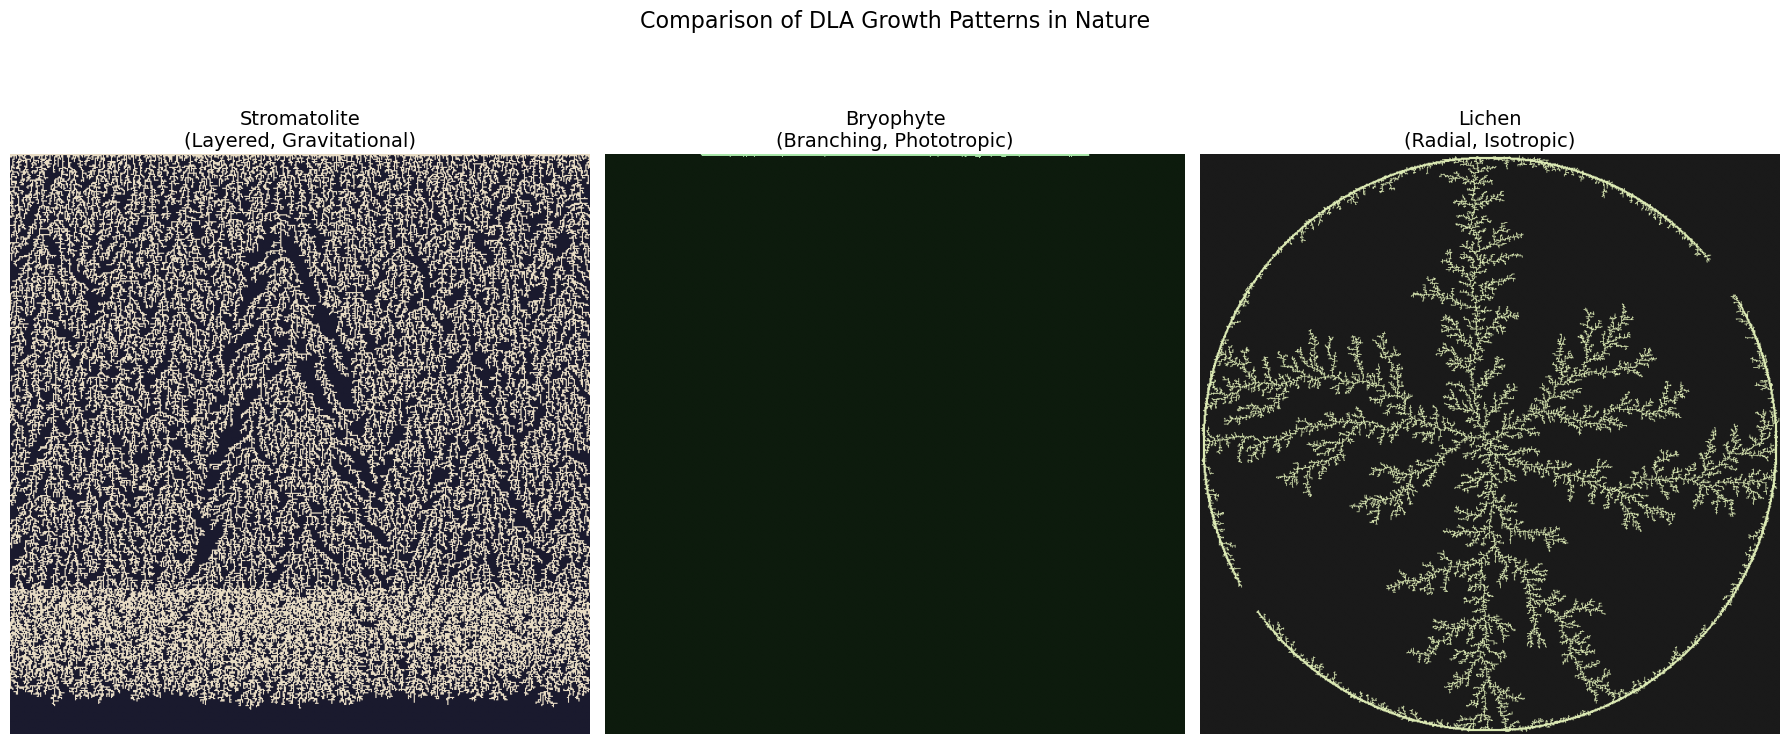

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Stromatolite
axes[0].imshow(stromatolite_grid.T, cmap=stromatolite_cmap, origin='lower')
axes[0].set_title('Stromatolite\n(Layered, Gravitational)', fontsize=14)
axes[0].axis('off')

# Bryophyte
axes[1].imshow(bryophyte_grid.T, cmap=bryophyte_cmap, origin='lower')
axes[1].set_title('Bryophyte\n(Branching, Phototropic)', fontsize=14)
axes[1].axis('off')

# Lichen
axes[2].imshow(lichen_grid.T, cmap=lichen_cmap, origin='lower')
axes[2].set_title('Lichen\n(Radial, Isotropic)', fontsize=14)
axes[2].axis('off')

plt.suptitle('Comparison of DLA Growth Patterns in Nature', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

---

## Interactive DLA Explorer

Use the sliders below to experiment with different DLA parameters and see how they affect the resulting structures.

In [15]:
@njit
def dla_interactive(grid_size, num_particles, max_steps, sticking_prob, bias_type):
    """
    Interactive DLA simulation with configurable bias.
    
    bias_type: 0=radial (lichen), 1=upward (bryophyte), 2=downward (stromatolite)
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    center = grid_size // 2
    
    # Set up seed based on bias type
    if bias_type == 0:  # Radial
        grid[center, center] = 1
    elif bias_type == 1:  # Upward (bryophyte)
        for x in range(center - 10, center + 10):
            grid[x, grid_size - 1] = 1
    else:  # Downward (stromatolite)
        for x in range(grid_size):
            grid[x, grid_size - 1] = 1
    
    particles_added = 0
    
    for _ in range(num_particles * 3):
        if particles_added >= num_particles:
            break
        
        # Spawn position based on bias type
        if bias_type == 0:  # Radial
            angle = 2 * np.pi * np.random.rand()
            x = int(center + (grid_size // 2 - 10) * np.cos(angle))
            y = int(center + (grid_size // 2 - 10) * np.sin(angle))
        elif bias_type == 1:  # Upward
            x = np.random.randint(center - grid_size // 3, center + grid_size // 3)
            y = grid_size - 1
        else:  # Downward
            x = np.random.randint(0, grid_size)
            y = 0
        
        x = max(1, min(x, grid_size - 2))
        y = max(1, min(y, grid_size - 2))
        
        for step in range(max_steps):
            # Movement based on bias type
            prob = np.random.rand()
            if bias_type == 0:  # Radial (unbiased)
                direction = np.random.randint(4)
                if direction == 0:
                    x = max(x - 1, 1)
                elif direction == 1:
                    x = min(x + 1, grid_size - 2)
                elif direction == 2:
                    y = max(y - 1, 1)
                else:
                    y = min(y + 1, grid_size - 2)
            elif bias_type == 1:  # Upward
                if prob < 0.55:
                    y = max(y - 1, 1)
                elif prob < 0.75:
                    x = max(x - 1, 1)
                elif prob < 0.95:
                    x = min(x + 1, grid_size - 2)
                else:
                    y = min(y + 1, grid_size - 2)
            else:  # Downward
                if prob < 0.5:
                    y = min(y + 1, grid_size - 2)
                elif prob < 0.7:
                    x = max(x - 1, 1)
                elif prob < 0.9:
                    x = min(x + 1, grid_size - 2)
                else:
                    y = max(y - 1, 1)
            
            # Check adjacency
            is_adjacent = (grid[x - 1, y] == 1 or grid[x + 1, y] == 1 or
                          grid[x, y - 1] == 1 or grid[x, y + 1] == 1)
            
            if is_adjacent:
                if np.random.rand() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                break
    
    return grid


def plot_interactive_dla(grid_size, num_particles, sticking_prob, growth_type):
    """Plot DLA with interactive parameters."""
    bias_map = {'Lichen (Radial)': 0, 'Bryophyte (Upward)': 1, 'Stromatolite (Downward)': 2}
    cmap_map = {'Lichen (Radial)': lichen_cmap, 'Bryophyte (Upward)': bryophyte_cmap, 
                'Stromatolite (Downward)': stromatolite_cmap}
    
    grid = dla_interactive(grid_size, num_particles, 50000, sticking_prob, bias_map[growth_type])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.T, cmap=cmap_map[growth_type], origin='lower')
    plt.title(f'{growth_type}\nGrid: {grid_size}, Particles: {num_particles}, Sticking: {sticking_prob:.2f}')
    plt.axis('off')
    plt.show()


# Create interactive widget
interact(
    plot_interactive_dla,
    grid_size=widgets.IntSlider(min=100, max=400, step=50, value=200, description='Grid Size'),
    num_particles=widgets.IntSlider(min=5000, max=50000, step=5000, value=20000, description='Particles'),
    sticking_prob=widgets.FloatSlider(min=0.2, max=1.0, step=0.1, value=0.6, description='Sticking Prob'),
    growth_type=widgets.Dropdown(
        options=['Lichen (Radial)', 'Bryophyte (Upward)', 'Stromatolite (Downward)'],
        value='Lichen (Radial)',
        description='Type'
    )
);

interactive(children=(IntSlider(value=200, description='Grid Size', max=400, min=100, step=50), IntSlider(valu…

---

## 3D Visualization with Plotly

Let's visualize the lichen DLA structure as a 3D surface where height represents particle density.

In [17]:
# Create a smoothed version for 3D visualization
from scipy.ndimage import gaussian_filter

# Downsample and smooth for better visualization
downsample = 4
lichen_small = lichen_grid[::downsample, ::downsample]
lichen_smooth = gaussian_filter(lichen_small.astype(float), sigma=1)

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=lichen_smooth,
    colorscale='Greens',
    showscale=False
)])

fig.update_layout(
    title='3D Visualization of Lichen DLA Structure',
    width=800,
    height=800,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Density',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    )
)

fig.show()

ModuleNotFoundError: No module named 'scipy'

---

## Summary

In this notebook, we explored **Diffusion Limited Aggregation (DLA)** as a model for understanding natural fractal growth patterns. We demonstrated how simple modifications to the basic DLA algorithm can simulate diverse biological structures:

| Organism | Growth Pattern | Key Parameters | Fractal Character |
|----------|---------------|----------------|------------------|
| **Stromatolite** | Layered, dome-like | Downward bias, horizontal seed | Stacked, branching columns |
| **Bryophyte** | Branching, vertical | Upward bias, low sticking | Dendritic, tree-like |
| **Lichen** | Radial, spreading | Isotropic, central seed | Classic DLA dendrites |

### Key Takeaways

1. **Simple rules create complexity**: DLA demonstrates how complex fractal structures emerge from simple random processes
2. **Bias shapes structure**: Directional biases in random walks dramatically change the resulting morphology
3. **Sticking probability controls branching**: Lower sticking probabilities create more branched, penetrating structures
4. **Universal patterns**: Despite different biology, many natural structures share underlying DLA-like growth mechanisms

### Further Exploration

Try modifying the simulations to explore:
- Multiple seed points (colony formation)
- Time-varying parameters (changing environmental conditions)
- 3D DLA simulations
- Adding nutrients or resource gradients

---

## References

### DLA and Fractals

1. Witten, T. A., & Sander, L. M. (1981). Diffusion-Limited Aggregation, a Kinetic Critical Phenomenon. *Physical Review Letters*, 47(19), 1400-1403.

2. Meakin, P. (1998). *Fractals, Scaling and Growth Far from Equilibrium*. Cambridge University Press.

3. Ben-Jacob, E., & Garik, P. (1990). The formation of patterns in non-equilibrium growth. *Nature*, 343(6258), 523-530.

### Biological Growth Patterns

4. Grosberg, R. K., & Strathmann, R. R. (2007). The Evolution of Multicellularity: A Minor Major Transition? *Annual Review of Ecology, Evolution, and Systematics*, 38, 621-654.

5. Allwood, A. C., et al. (2006). Stromatolite reef from the Early Archaean era of Australia. *Nature*, 441(7094), 714-718.

### Lichen Biology and Growth Forms

6. Nash, T. H. (2008). *Lichen Biology* (2nd ed.). Cambridge University Press.

7. Brodo, I. M., Sharnoff, S. D., & Sharnoff, S. (2001). *Lichens of North America*. Yale University Press.

8. [Lichen Growth Forms](https://en.wikipedia.org/wiki/Lichen_growth_forms) - Wikipedia

9. [Lichen Morphology](https://britishlichensociety.org.uk/learning/lichen-morphology) - British Lichen Society

10. Armstrong, R. A. (1988). Radial growth of Rhizocarpon geographicum on rock surfaces. *Lichenologist*, 20(1), 1-11.